In [0]:
import pandas as pd
import ast
import numpy as np
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
tf.disable_v2_behavior()

In [61]:
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Load Data**

In [62]:
movies = pd. read_csv('/content/drive/My Drive/SWM/the-movies-dataset/movies_metadata.csv')
extlinks = pd.read_csv('/content/drive/My Drive/SWM/the-movies-dataset/links_small.csv')
ratings = pd.read_csv('/content/drive/My Drive/SWM/the-movies-dataset/ratings_small.csv')
extlinks.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [63]:
credits = pd.read_csv('/content/drive/My Drive/SWM/the-movies-dataset/credits.csv')
keywords = pd.read_csv('/content/drive/My Drive/SWM/the-movies-dataset/keywords.csv')
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [0]:
movies = movies.drop([19730, 29503, 35587])
extlinks = extlinks[extlinks['tmdbId'].notnull()]['tmdbId'].astype('int')

In [0]:
movies['genres'] = movies['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda genres: [genre['name'] for genre in genres] if isinstance(genres, list) else [])

In [0]:
movies['id'] = movies['id'].astype('int')
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movies = movies.merge(credits, on='id')
movies = movies.merge(keywords, on='id')

In [67]:
movies_filtered = movies[movies['id'].isin(extlinks)]
movies_filtered.head()
movies_filtered.shape

(9219, 27)

**2. Extract Meta Data (Cast, Crew and Keywords)**

In [68]:
movies_filtered['cast'] = movies_filtered['cast'].apply(ast.literal_eval)
movies_filtered['crew'] = movies_filtered['crew'].apply(ast.literal_eval)
movies_filtered['keywords'] = movies_filtered['keywords'].apply(ast.literal_eval)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [69]:
movies_filtered['cast_size'] = movies_filtered['cast'].apply(lambda x: len(x))
movies_filtered['crew_size'] = movies_filtered['crew'].apply(lambda x: len(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**3. Extract Director Name From Crew**

In [70]:
def getDirector(crew):
  for person in crew:
    if person['job'] == 'Director':
          return person['name']
  return np.nan
movies_filtered['director'] = movies_filtered['crew'].apply(getDirector)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
movies_filtered['cast']  = movies_filtered['cast'].apply(lambda cast: [person['name'] for person in cast] if isinstance(cast, list) else [])
movies_filtered['cast'] = movies_filtered['cast'].apply(lambda cast: cast[:3] if len(cast) >=3 else cast)
movies_filtered['cast']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0                      [Tom Hanks, Tim Allen, Don Rickles]
1           [Robin Williams, Jonathan Hyde, Kirsten Dunst]
2               [Walter Matthau, Jack Lemmon, Ann-Margret]
3        [Whitney Houston, Angela Bassett, Loretta Devine]
4               [Steve Martin, Diane Keaton, Martin Short]
                               ...                        
40952      [Sidney Poitier, Wendy Crewson, Jay O. Sanders]
41172            [Akshay Kumar, Ileana D'Cruz, Esha Gupta]
41225            [Hrithik Roshan, Pooja Hegde, Kabir Bedi]
41391    [Hiroki Hasegawa, Yutaka Takenouchi, Satomi Is...
41669           [Paul McCartney, Ringo Starr, John Lennon]
Name: cast, Length: 9219, dtype: object

In [72]:
movies_filtered['keywords'] = movies_filtered['keywords'].apply(lambda keywords: [keyword['name'] for keyword in keywords] if isinstance(keywords, list) else [])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [73]:
movies_filtered['director'] = movies_filtered['director'].astype('str').apply(lambda name: str.lower(name.replace(" ", "")))
movies_filtered['director'] = movies_filtered['director'].apply(lambda name: [name, name, name])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [74]:
keywords = movies_filtered.apply(lambda movie: pd.Series(movie['keywords']),axis=1).stack().reset_index(level=1, drop=True)
keywords = keywords.value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [75]:
keywords = keywords[keywords>1]
keywords.head()

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
dtype: int64

In [0]:
def filterKeywords(list):
  words = []
  for word in list:
    if word in keywords:
      words.append(word)
  return words

In [77]:
movies_filtered['keywords'] = movies_filtered['keywords'].apply(filterKeywords)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [78]:
movies_filtered['keywords'] = movies_filtered['keywords'].apply(lambda movieKeywords: [SnowballStemmer('english').stem(word) for word in movieKeywords])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [79]:
movies_filtered['keywords'] = movies_filtered['keywords'].apply(lambda movieKeywords: [str.lower(word.replace(" ", "")) for word in movieKeywords])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**4. Create Meta Data Dump**

In [80]:
movies_filtered['document'] = movies_filtered['keywords'] + movies_filtered['cast'] + movies_filtered['director'] + movies_filtered['genres']
movies_filtered['document'] = movies_filtered['document'].apply(lambda x: ' '.join(x))
movies_filtered['document'] 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0        jealousi toy boy friendship friend rivalri boy...
1        boardgam disappear basedonchildren'sbook newho...
2        fish bestfriend duringcreditssting Walter Matt...
3        basedonnovel interracialrelationship singlemot...
4        babi midlifecrisi confid age daughter motherda...
                               ...                        
40952    friendship Sidney Poitier Wendy Crewson Jay O....
41172    bollywood Akshay Kumar Ileana D'Cruz Esha Gupt...
41225    bollywood Hrithik Roshan Pooja Hegde Kabir Bed...
41391    monster godzilla giantmonst destruct kaiju Hir...
41669    music documentari Paul McCartney Ringo Starr J...
Name: document, Length: 9219, dtype: object

In [0]:
count_vector = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count_vector.fit_transform(movies_filtered['document'] )
similarity = cosine_similarity(count_matrix, count_matrix)

In [0]:
movies_filtered = movies_filtered.reset_index()
titles = movies_filtered['title']
indices = pd.Series(movies_filtered.index, index=movies_filtered['title'])

**5. Get Content Based Recommendations**

In [0]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [0]:
content_based_recommendations = get_recommendations('Batman Begins').head(10)

In [85]:
ratings.count()

userId       100004
movieId      100004
rating       100004
timestamp    100004
dtype: int64

**6. Convert String to numbers**

In [86]:
ratings.userId = ratings.userId.astype(str).astype(int)
ratings.movieId = ratings.movieId.astype(str).astype(int)
ratings.rating = ratings.rating.astype(str).astype(float)
ratings.timestamp = pd.to_datetime(ratings.timestamp.astype(int), unit='s')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,2009-12-14 02:52:24
1,1,1029,3.0,2009-12-14 02:52:59
2,1,1061,3.0,2009-12-14 02:53:02
3,1,1129,2.0,2009-12-14 02:53:05
4,1,1172,4.0,2009-12-14 02:53:25


In [87]:
len(movies_filtered)

9219

In [0]:
movies_filtered['List Index']=movies_filtered.index.astype(str).astype(int)

In [0]:
data_combined=pd.merge(movies_filtered, ratings, left_on='id' , right_on='movieId')

In [0]:
def getCombinedData():
  return data_combined

In [91]:
data_combined = data_combined[['movieId', 'List Index', 'userId', 'rating']]
data_combined['List Index']=data_combined['List Index'].astype(str).astype(int)
data_combined.head()

,movieId,List Index,userId,rating
0,949,5,23,3.5
1,949,5,102,4.0
2,949,5,232,2.0
3,949,5,242,5.0
4,949,5,263,3.0


**7. Group By UserId**

In [0]:
user_group = data_combined.groupby('userId')

In [93]:
n_users = user_group.first().shape[0]
n_users

671

**8. Create User Movie Rating matrix**

In [0]:
totalUsers=n_users
user_movie = [None]* n_users

for userId, curUser in user_group:
  temp = [0]* len(movies_filtered)

  for num, movie in curUser.iterrows():
    temp[int(movie['List Index'])] = movie['rating']/5.0
  user_movie[userId-1]=temp

  if totalUsers == 0:
    break
  totalUsers-=1

In [95]:
len(user_movie)

671

**9. Create RBM Layers**

In [0]:
hidden_units=256
visible_units = len(movies_filtered)
visible = tf.placeholder("float", [visible_units])
hidden = tf.placeholder("float", [hidden_units])
w= tf.placeholder("float", [visible_units, hidden_units])

**10. Forward pass**

In [0]:
v0 = tf.placeholder("float", [None, visible_units])
_h0 = tf.nn.sigmoid(tf.matmul(v0, w)+hidden)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

**11. Backward pass**

In [0]:
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(w))+visible)  
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, w)+ hidden)

In [0]:
alpha = 0.5
positive_phase = tf.matmul(tf.transpose(v0), h0)
negative_phase = tf.matmul(tf.transpose(v1), h1)
contrastive_divergernce = positive_phase - negative_phase
contrastive_divergernce = contrastive_divergernce/tf.to_float(tf.shape(v0)[0])
update_w = w+ alpha * contrastive_divergernce
update_vb = visible + alpha * tf.reduce_mean(v0-v1, 0)
update_hb = hidden + alpha * tf.reduce_mean(h0-h1, 0)

In [0]:
err = v0-v1
err_sum = tf.reduce_mean(err * err)

In [0]:
cur_w = np.zeros([visible_units, hidden_units], np.float32)
cur_vb = np.zeros([visible_units], np.float32)
cur_hb = np.zeros([hidden_units], np.float32)

prev_w = np.zeros([visible_units, hidden_units], np.float32)
prev_vb = np.zeros([visible_units], np.float32)
prev_hb = np.zeros([hidden_units], np.float32)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

**12. Train the model**

In [102]:
epochs=20
batchsize=20
errors=[]
for i in range(epochs):
  for start, end in zip(range(0, len(user_movie), batchsize), range(batchsize, len(user_movie), batchsize) ):
    batch = user_movie[start:end]
    cur_w = sess.run(update_w, feed_dict={v0 : batch, w : prev_w, visible: prev_vb , hidden : prev_hb})
    cur_vb = sess.run(update_vb, feed_dict={v0 : batch, w : prev_w, visible: prev_vb , hidden : prev_hb})
    cur_hb = sess.run(update_hb, feed_dict={v0 : batch, w : prev_w, visible: prev_vb , hidden : prev_hb})
    prev_w = cur_w
    prev_vb = prev_vb
    prev_hb = prev_hb
  errors.append(sess.run(err_sum, feed_dict={v0 : user_movie, w : cur_w, visible: cur_vb , hidden : cur_hb}))
  print(errors[-1])


0.03696533
0.023994155
0.020508904
0.01839812
0.016867168
0.016318215
0.015423574
0.014647556
0.013639659
0.0133565655
0.012810909
0.0122020785
0.012166869
0.011748016
0.011321535
0.010944227
0.010292557
0.010388645
0.010070052
0.009865913


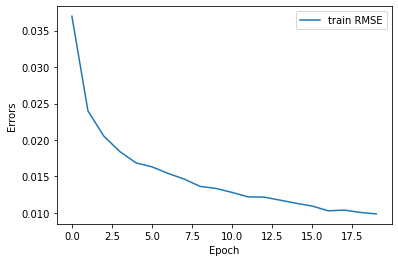

In [103]:
plt.plot(errors, label="train RMSE")
plt.ylabel('Errors')
plt.legend()
plt.xlabel('Epoch')
plt.show()

**13. Predict For Test User**

In [0]:
testUserId =21
testUser = [user_movie[testUserId-1]]

In [0]:
hh0 = tf.nn.sigmoid(tf.matmul(v0, w)+hidden)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(w))+visible)
feed = sess.run(hh0, feed_dict={v0 : testUser, w: prev_w, hidden : prev_hb})
rec = sess.run(vv1, feed_dict={hh0 : feed, w: prev_w, visible : prev_vb})

In [0]:
scored_movies=movies_filtered
scored_movies['Recommended Scores']=rec[0]

In [107]:
scored_movies.sort_values(['Recommended Scores'], ascending=False).head(10)

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords,cast_size,crew_size,director,document,List Index,Recommended Scores
4106,5239,False,NaN,0,[Documentary],http://www.sonypictures.com/classics/dogtown/,1282,tt0275309,en,Dogtown and Z-Boys,Dogtown and Z-Boys follows the evolution of sk...,4.70409,/yS11joPn962PSp8iBsmcaZLWN4M.jpg,"[{'name': 'Agi Orsi Productions', 'id': 794}, ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2001-01-18,0.0,91.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Dogtown and Z-Boys,False,7.2,53.0,"[Sean Penn, Jay Adams, Henry Rollins]","[{'credit_id': '52fe42edc3a36847f802d873', 'de...","[skateboard, independentfilm]",9,7,"[stacyperalta, stacyperalta, stacyperalta]",skateboard independentfilm Sean Penn Jay Adams...,4106,0.998474
2155,2576,False,NaN,42000000,"[Romance, Comedy, Drama]",http://www.notting-hill.com/,509,tt0125439,en,Notting Hill,The British comedy from director Roger Michell...,9.87404,/f1gMw3PVicfdq9thlvUIjJ5UdvS.jpg,"[{'name': 'Bookshop Productions', 'id': 282}, ...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1999-05-13,363889678.0,124.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Can the most famous film star in the world fal...,Notting Hill,False,7.0,1309.0,"[Julia Roberts, Hugh Grant, Gina McKee]","[{'credit_id': '52fe424cc3a36847f8013427', 'de...","[londonengland, bookshop, birthday, newlov, fi...",27,11,"[rogermichell, rogermichell, rogermichell]",londonengland bookshop birthday newlov filmmak...,2155,0.996324
6205,10177,False,"{'id': 14740, 'name': 'Madagascar Collection',...",75000000,"[Family, Animation]",NaN,953,tt0351283,en,Madagascar,Zoo animals leave the comforts of man-made hab...,16.1362,/2YiESGB68BGQSAFvfJxBi774sc4.jpg,"[{'name': 'DreamWorks SKG', 'id': 27}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2005-05-25,532680671.0,86.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Someone's got a zoo loose.,Madagascar,False,6.6,3322.0,"[Ben Stiller, Chris Rock, David Schwimmer]","[{'credit_id': '557caebfc3a3686334002304', 'de...","[lion, hippopotamus, giraff, penguin, zebra]",21,55,"[ericdarnell, ericdarnell, ericdarnell]",lion hippopotamus giraff penguin zebra Ben Sti...,6205,0.995655
6664,11590,False,NaN,15000000,"[Drama, Romance]",http://www.foxsearchlight.com/NOAS/,1259,tt0465551,en,Notes on a Scandal,A veteran high school teacher befriends a youn...,8.59309,/auGdbhh2LklmZV1LLLwQ5uvHiX4.jpg,"[{'name': 'Fox Searchlight Pictures', 'id': 43...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2006-12-25,49469904.0,92.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,One woman's secret is another woman's power. O...,Notes on a Scandal,False,6.9,239.0,"[Judi Dench, Cate Blanchett, Bill Nighy]","[{'credit_id': '52fe42ebc3a36847f802cc2b', 'de...","[sex, adulteri, basedonnovel, cat, infidel, se...",23,15,"[richardeyre, richardeyre, richardeyre]",sex adulteri basedonnovel cat infidel secret o...,6664,0.994807
1938,2318,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",31000000,[Drama],NaN,1374,tt0089927,en,Rocky IV,Rocky must come out of retirement to battle a ...,10.2572,/q2nkVddOshjhJ19oQYmViQHxyjj.jpg,"[{'name': 'United Artists', 'id': 60}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1985-11-21,300473716.0,91.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,He's facing the ultimate challenge. And fighti...,Rocky IV,False,6.6,984.0,"[Sylvester Stallone, Talia Shire, Burt Young]","[{'credit_id': '52fe42f1c3a36847f802e859', 'de...","[usa, transport, lossoflov, coldwar, sovietuni...",20,18,"[sylvesterstallone, sylvesterstallone, sylvest...",usa transport lossoflov coldwar sovietunion bo...,1938,0.993064
2231,2676,False,NaN,4300000,"[Roma

In [0]:
def predict(userId):
  testUser = [user_movie[userId-1]]
  hh0 = tf.nn.sigmoid(tf.matmul(v0, w)+hidden)
  vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(w))+visible)
  feed = sess.run(hh0, feed_dict={v0 : testUser, w: prev_w, hidden : prev_hb})
  rec = sess.run(vv1, feed_dict={hh0 : feed, w: prev_w, visible : prev_vb})
  scored_movies['Recommended Scores']=rec[0]
  return scored_movies

In [0]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

**14. Hybrid Model**

In [0]:
id_map = pd.read_csv('/content/drive/My Drive/SWM/the-movies-dataset/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(movies_filtered[['title', 'id']], on='id').set_index('title')


In [0]:
indices_map = id_map.set_index('id')

In [0]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(similarity[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = movies_filtered.iloc[movie_indices][['title', 'id']]
    recommendations=predict(userId)
    recommendations1 = recommendations[recommendations['id'].isin(movies['id'])]
    recommendations1 = recommendations1.sort_values('Recommended Scores', ascending=False)
    
    return recommendations1[['title', 'id', 'genres', 'Recommended Scores']].head(10)

In [119]:
print("Movie Recommendations From Hybrid Model : ")
hybrid(4,"Harry Potter and the Chamber of Secrets")

Movie Recommendations From Hybrid Model : 


,title,id,genres,Recommended Scores
3840,Harry Potter and the Philosopher's Stone,671,"[Adventure, Fantasy, Family]",0.232007
6354,Harry Potter and the Goblet of Fire,674,"[Adventure, Fantasy, Family]",0.182640
447,Mrs. Doubtfire,788,"[Comedy, Drama, Family]",0.150160
5452,Harry Potter and the Prisoner of Azkaban,673,"[Adventure, Fantasy, Family]",0.053377
6357,Rent,1833,"[Drama, Romance]",0.005870
853,Bedknobs and Broomsticks,12335,"[Adventure, Fantasy, Animation, Comedy, Family...",0.002914
7377,"I Love You, Beth Cooper",19840,"[Comedy, Romance]",0.002884
7345,Harry Potter and the Half-Blood Prince,767,"[Adventure, Fantasy, Family]",0.002172
7921,Harry Potter and the Deathly Hallows: Part 2,12445,"[Family, Fantasy, Adventure]",0.002057
8996,Pixels,257344,"[Action, Comedy, Science Fiction]",0.001917
